###### Forecst Store Sales using a Kaggle Dataset
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

# Import Libraries and load the data

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_log_error
#from sklearn.metrics import mean_squared_error

In [69]:
# load all the data files into dataframes

df_train = pd.read_csv('data/train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_test = pd.read_csv('data/test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
df_holidays = pd.read_csv('data/holidays_events.csv', parse_dates = ['date'], infer_datetime_format = True)
df_oil = pd.read_csv('data/oil.csv',  parse_dates = ['date'], infer_datetime_format = True)
df_sample_submission = pd.read_csv('data/sample_submission.csv',index_col='id')
df_stores = pd.read_csv('data/stores.csv')
df_transactions = pd.read_csv('data/train.csv',  parse_dates = ['date'], infer_datetime_format = True)

## Profile holidays data frame

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [3]:
df_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [4]:
df_holidays.sample(25)

,date,type,locale,locale_name,description,transferred
173,2015-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
243,2016-05-07,Event,National,Ecuador,Terremoto Manabi+21,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
189,2015-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False
118,2014-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
275,2016-11-02,Holiday,National,Ecuador,Dia de Difuntos,False
131,2014-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
228,2016-04-24,Event,National,Ecuador,Terremoto Manabi+8,False
259,2016-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False


## Profile Stores dataframe
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores

In [5]:
df_stores.sample(25)

,store_nbr,city,state,type,cluster
48,49,Quito,Pichincha,A,11
33,34,Guayaquil,Guayas,B,6
29,30,Guayaquil,Guayas,C,3
25,26,Guayaquil,Guayas,D,10
20,21,Santo Domingo,Santo Domingo de los Tsachilas,B,6
2,3,Quito,Pichincha,D,8
15,16,Santo Domingo,Santo Domingo de los Tsachilas,C,3
9,10,Quito,Pichincha,C,15
27,28,Guayaquil,Guayas,E,10
31,32,Guayaquil,Guayas,C,3


Text(0.5, 1.0, 'Number of Stores by Type and Cluster')

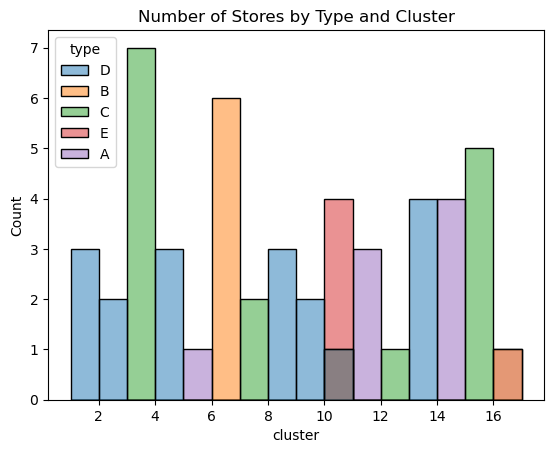

In [6]:
sns.histplot(data = df_stores
            , x='cluster'
            , hue='type'
            ,binwidth = 1).set_title('Number of Stores by Type and Cluster')

### Findings
* Store type and Store Cluster seem to be providing similar information. Only Cluster 10 has 2 different types of stores in it

## Profile the oil datframe
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

In [7]:
df_oil.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [8]:
df_oil.tail(20)

,date,dcoilwtico
1198,2017-08-04,49.57
1199,2017-08-07,49.37
1200,2017-08-08,49.07
1201,2017-08-09,49.59
1202,2017-08-10,48.54
1203,2017-08-11,48.81
1204,2017-08-14,47.59
1205,2017-08-15,47.57
1206,2017-08-16,46.80
1207,2017-08-17,47.07


In [9]:
# find null values
df_oil[df_oil['dcoilwtico'].isnull()].count()

date          43
dcoilwtico     0
dtype: int64

Text(0.5, 1.0, 'Trend of Oil Prices')

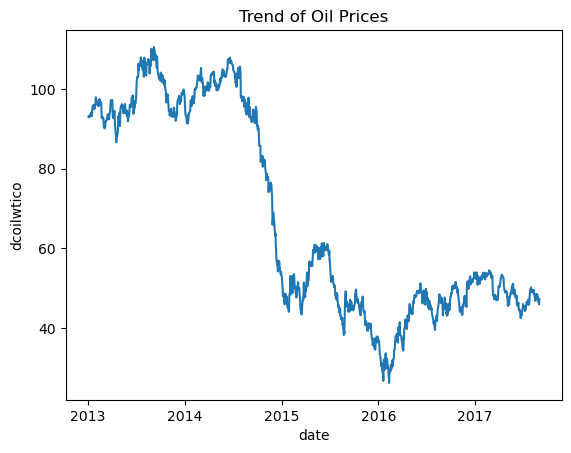

In [10]:
sns.lineplot(data=df_oil,  x='date', y='dcoilwtico').set_title('Trend of Oil Prices')

### Findings
* The datasets starts with 0 and there are several missing values
* There is a step function drop arund 2015 and several peaks and drops in the dataset
* The time series has missing dates as well




# Profile the transactions dataset

In [11]:
df_transactions.head(15)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [12]:
df_transactions.tail(5)

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [13]:
df_transactions.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [14]:
df_transactions.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [15]:
#sns.lineplot(data=df_transactions
#             ,  x='date'
#             , y='sales'
#            ,hue='store_nbr').set_title('Trend of Sales by Store')

In [16]:
df_train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [17]:
df_train.tail()

,date,store_nbr,family,sales,onpromotion
id,,,,,
3000883,2017-08-15,9,POULTRY,438.133,0
3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,2017-08-15,9,SEAFOOD,16.000,0


## Feature Engineering and creating the final Train and Test datasets
* Holiday dataset to that it is an additional regressor at the store and region level
* Oil dataset so that it is an additional regressor
* Store dataset to get stores in same regons that might be running promotions that impact sales
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake

### Feature engineering on the holidays

Notes from Kaggle for Holidays and Events, with metadata
NOTE: 

Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. 

Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [112]:
# create a time series for holidays
# create a time series dataframe from start to an additional 15 days that need to be forecasted
holiday_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [105]:
#remove holidays that were transferred
df_holiday_clean = df_holidays.query('transferred!=True').copy()
df_holiday_clean.sample(20)

,date,type,locale,locale_name,description,transferred
276,2016-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
329,2017-09-29,Transfer,Local,Ibarra,Fundacion de Ibarra,False
109,2014-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
247,2016-05-10,Event,National,Ecuador,Terremoto Manabi+24,False
309,2017-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
8,2012-06-25,Holiday,Local,Latacunga,Cantonizacion de Latacunga,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False
82,2013-12-06,Holiday,Local,Quito,Fundacion de Quito,False
270,2016-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [117]:
# national holidays, additional days and events
df_national_holiday = df_holiday_clean.query("locale=='National' and type!='Work Day'")
df_national_holiday.sample(10)

,date,type,locale,locale_name,description,transferred
331,2017-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,False
33,2012-12-22,Additional,National,Ecuador,Navidad-3,False
101,2014-05-01,Holiday,National,Ecuador,Dia del Trabajo,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
220,2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False
94,2014-03-03,Holiday,National,Ecuador,Carnaval,False
232,2016-04-28,Event,National,Ecuador,Terremoto Manabi+12,False
225,2016-04-21,Event,National,Ecuador,Terremoto Manabi+5,False
306,2017-04-14,Holiday,National,Ecuador,Viernes Santo,False
254,2016-05-16,Event,National,Ecuador,Terremoto Manabi+30,False


In [123]:
#regional holidays
df_regional_holiday = df_holiday_clean.query("locale=='Regional' and type!='Work Day'")
df_regional_holiday.sample(10)

,date,type,locale,locale_name,description,transferred
334,2017-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
58,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
96,2014-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
193,2015-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
279,2016-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
76,2013-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
216,2016-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
259,2016-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
24,2012-11-07,Holiday,Regional,Santa Elena,Provincializacion Santa Elena,False
139,2014-11-06,Holiday,Regional,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False


In [124]:
#local holidays
df_local_holiday = df_holiday_clean.query("locale=='Local' and type!='Work Day'")
df_local_holiday.sample(10)


,date,type,locale,locale_name,description,transferred
282,2016-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
68,2013-08-15,Holiday,Local,Riobamba,Fundacion de Riobamba,False
262,2016-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
175,2015-06-23,Holiday,Local,Guaranda,Cantonizacion de Guaranda,False
164,2015-03-02,Holiday,Local,Manta,Fundacion de Manta,False
197,2015-11-12,Holiday,Local,Ambato,Independencia de Ambato,False
301,2017-03-02,Holiday,Local,Manta,Fundacion de Manta,False
287,2016-12-06,Holiday,Local,Quito,Fundacion de Quito,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
263,2016-07-23,Holiday,Local,Cayambe,Cantonizacion de Cayambe,False


### Feature engineering on the oil dataset
* Filling missing values and added it to the test and train dataset
* adding missing dates to the dataset

In [70]:
# create a time series dataframe from start to an additional 15 days that need to be forecasted
oil_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [71]:
# merge the oil data into the new dataframe so that there are no missing dates
oil_ts = pd.merge(oil_ts,df_oil , how="left", on="date").copy()

In [72]:
oil_ts.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN
5,2013-01-06,NaN
6,2013-01-07,93.20
7,2013-01-08,93.21
8,2013-01-09,93.08
9,2013-01-10,93.81


In [73]:
oil_ts.tail(20)

,date,dcoilwtico
1684,2017-08-12,NaN
1685,2017-08-13,NaN
1686,2017-08-14,47.59
1687,2017-08-15,47.57
1688,2017-08-16,46.80
1689,2017-08-17,47.07
1690,2017-08-18,48.59
1691,2017-08-19,NaN
1692,2017-08-20,NaN
1693,2017-08-21,47.39


In [74]:
# fill the oil data that is missing with the next non missing value
oil_ts['dcoilwtico'].fillna(method='backfill', inplace=True)

In [75]:
oil_ts[oil_ts['dcoilwtico'].isnull()]

,date,dcoilwtico


In [76]:
# add oil data to the test and train dataset
df_train = df_train.drop('dcoilwtico', axis=1, errors='ignore')
df_test = df_test.drop('dcoilwtico', axis=1, errors='ignore')


df_train = pd.merge(df_train,oil_ts , how="left", on="date").copy()
df_test = pd.merge(df_test,oil_ts , how="left", on="date").copy()
df_train.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14
1,2013-01-01,1,BABY CARE,0.0,0,93.14
2,2013-01-01,1,BEAUTY,0.0,0,93.14
3,2013-01-01,1,BEVERAGES,0.0,0,93.14
4,2013-01-01,1,BOOKS,0.0,0,93.14


### Create a dataset that has indicators for dates when wages are paid

In [77]:
#create the wages dataset
wages_ts = pd.DataFrame(pd.date_range(start='2013-01-01' , end='2017-08-31') , columns=['date'])

In [78]:
#indicator for 15th and last day of each month

wages_ts = wages_ts.drop('is_salary_day', axis=1, errors='ignore')

def wage_dates(col):
    if col['date'].is_month_end or col['date'].day==15:
        return 1
    else:
        return 0

wages_ts['is_salary_day'] = wages_ts.apply(wage_dates, axis=1)

wages_ts.head(60)

,date,is_salary_day
0,2013-01-01,0
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0
5,2013-01-06,0
6,2013-01-07,0
7,2013-01-08,0
8,2013-01-09,0
9,2013-01-10,0


In [79]:
# add wage days to the train and test dataset
df_train = df_train.drop('is_salary_day', axis=1, errors='ignore')
df_train = pd.merge(df_train,wages_ts , how="left", on="date").copy()

df_test = df_test.drop('is_salary_day', axis=1, errors='ignore')
df_test = pd.merge(df_test,wages_ts , how="left", on="date").copy()

In [80]:
df_train.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,is_salary_day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,0
1,2013-01-01,1,BABY CARE,0.0,0,93.14,0
2,2013-01-01,1,BEAUTY,0.0,0,93.14,0
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,0
4,2013-01-01,1,BOOKS,0.0,0,93.14,0


## Train the Prophet model for a single store and family to build framework

In [81]:
#creaate a copy and check the data types
df_train_p = pd.DataFrame()
df_train_p = df_train.query("store_nbr == 9 and family == 'PREPARED FOODS' ").copy(deep=True)
df_train_p.dtypes

date             datetime64[ns]
store_nbr                 int64
family                   object
sales                   float64
onpromotion               int64
dcoilwtico              float64
is_salary_day             int64
dtype: object

In [82]:
#rename the columns
df_train_p.rename(columns={'date':'ds','sales':'y'}, inplace=True)

In [83]:
df_train_p.head()

,ds,store_nbr,family,y,onpromotion,dcoilwtico,is_salary_day
1778,2013-01-01,9,PREPARED FOODS,0.0,0,93.14,0
3560,2013-01-02,9,PREPARED FOODS,83.0,0,93.14,0
5342,2013-01-03,9,PREPARED FOODS,66.0,0,92.97,0
7124,2013-01-04,9,PREPARED FOODS,57.0,0,93.12,0
8906,2013-01-05,9,PREPARED FOODS,84.0,0,93.20,0


In [93]:
#train the model
model = Prophet()
model.add_regressor('dcoilwtico')
model.add_regressor('is_salary_day')
model.add_regressor('onpromotion')
model.fit(df_train_p)
model

19:29:22 - cmdstanpy - INFO - Chain [1] start processing
19:29:22 - cmdstanpy - INFO - Chain [1] done processing


In [94]:
#make predictions on the train data
preds = model.predict(df_train_p)
preds.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,dcoilwtico,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1679,2017-08-11,129.064664,78.929974,133.767504,129.064664,129.064664,-22.271958,-22.271958,-22.271958,-0.834368,...,-16.227796,-16.227796,-16.227796,-6.283498,-6.283498,-6.283498,0.0,0.0,0.0,106.792706
1680,2017-08-12,129.120496,121.239949,173.810358,129.120496,129.120496,17.855602,17.855602,17.855602,-0.887797,...,24.544457,24.544457,24.544457,-5.828095,-5.828095,-5.828095,0.0,0.0,0.0,146.976098
1681,2017-08-13,129.176328,130.614532,181.419950,129.176328,129.176328,26.508033,26.508033,26.508033,-0.887797,...,32.787968,32.787968,32.787968,-5.419175,-5.419175,-5.419175,0.0,0.0,0.0,155.684361
1682,2017-08-14,129.232159,87.497775,142.062418,129.232159,129.232159,-14.121744,-14.121744,-14.121744,-0.887797,...,-7.676041,-7.676041,-7.676041,-5.061610,-5.061610,-5.061610,0.0,0.0,0.0,115.110415
1683,2017-08-15,129.287991,91.146342,147.672181,129.287991,129.287991,-9.622513,-9.622513,-9.622513,-0.888673,...,-8.810269,-8.810269,-8.810269,-4.758670,-4.758670,-4.758670,0.0,0.0,0.0,119.665478


In [95]:
final_df= pd.concat([preds.set_index('ds'),df_train_p.set_index('ds')], axis=1, join='outer').reset_index()
final_df[['ds','y','yhat']].tail(20)

,ds,y,yhat
1664,2017-07-27,92.337000,104.937843
1665,2017-07-28,64.198000,99.739599
1666,2017-07-29,152.591000,139.701368
1667,2017-07-30,145.490000,148.235979
1668,2017-07-31,61.940000,112.419132
1669,2017-08-01,50.462997,106.859505
1670,2017-08-02,89.135000,101.896040
1671,2017-08-03,83.426000,106.861570
1672,2017-08-04,117.189000,102.617992
1673,2017-08-05,162.324000,142.935173


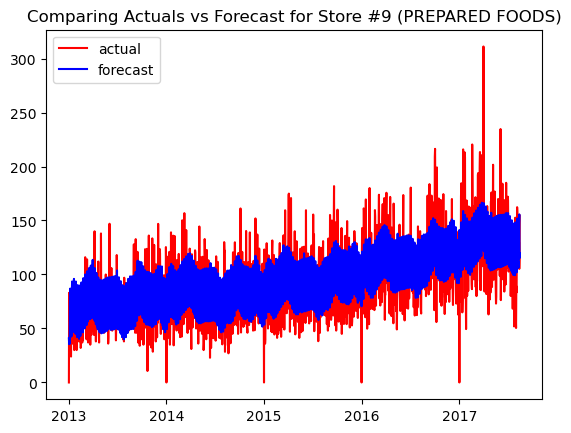

In [96]:
plt.plot(final_df['ds'] , final_df['y'], color='red' , label='actual')
plt.plot(final_df['ds'] , final_df['yhat'], color='blue' , label='forecast')
plt.title('Comparing Actuals vs Forecast for Store #9 (PREPARED FOODS)')
plt.legend()

In [97]:
train_preds = final_df.query("ds<='2017-08-15'")
msle = mean_squared_log_error(train_preds[['y']] , train_preds[['yhat']])
print("MSLE is ", msle)                                          

MSLE is  0.11421588957291484


In [89]:
#creaate a copy and check the data types
df_test_p = pd.DataFrame()
df_test_p = df_test.query("store_nbr == 9 and family == 'PREPARED FOODS' ").copy(deep=True)
df_test_p.dtypes

date             datetime64[ns]
store_nbr                 int64
family                   object
onpromotion               int64
dcoilwtico              float64
is_salary_day             int64
dtype: object

,ds,store_nbr,family,onpromotion,dcoilwtico,is_salary_day
28508,2017-08-31,9,PREPARED FOODS,0,NaN,NaN


In [90]:
df_test_p.rename(columns={'date':'ds','sales':'y'}, inplace=True)
preds = model.predict(df_test_p)
final_df= pd.concat([preds.set_index('ds'),df_train_p.set_index('ds')], axis=1, join='outer').reset_index()
final_df[['ds','y','yhat']].tail(20)


,ds,y,yhat
1680,2017-08-12,129.90399,NaN
1681,2017-08-13,105.16900,NaN
1682,2017-08-14,114.12000,NaN
1683,2017-08-15,154.55300,NaN
1684,2017-08-16,NaN,111.561321
1685,2017-08-17,NaN,114.764567
1686,2017-08-18,NaN,108.780765
1687,2017-08-19,NaN,149.422618
1688,2017-08-20,NaN,157.764551
1689,2017-08-21,NaN,117.364329


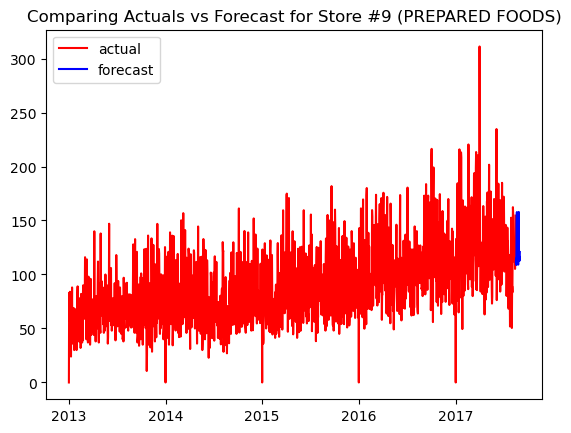

In [91]:
plt.plot(final_df['ds'] , final_df['y'], color='red' , label='actual')
plt.plot(final_df['ds'] , final_df['yhat'], color='blue' , label='forecast')
plt.title('Comparing Actuals vs Forecast for Store #9 (PREPARED FOODS)')
plt.legend()